In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

import statsmodels.formula.api as smf
import statsmodels
from shapely.geometry import Polygon

# read in data

In [137]:
ward = gpd.read_file("https://liveuclac-my.sharepoint.com/:u:/g/personal/ucfnghu_ucl_ac_uk/EfUGvfg-8PRKq29Ta55aSxABVlXy2kHDwfm2IeEELwiarw?raw=true") 

HTTPError: HTTP Error 403: Forbidden

In [2]:

url  = 'http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/data/listings.csv.gz'
airbnb_origin2022 = pd.read_csv(url, compression='gzip', low_memory=False)
airbnb_origin2022.info() #check data type, the first three columns are redundant information.
airbnb_origin2022.head()
print(f"Data frame is {airbnb_origin2022.shape[0]:,} x {airbnb_origin2022.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            69351 non-null  int64  
 1   listing_url                                   69351 non-null  object 
 2   scrape_id                                     69351 non-null  int64  
 3   last_scraped                                  69351 non-null  object 
 4   source                                        69351 non-null  object 
 5   name                                          69330 non-null  object 
 6   description                                   67832 non-null  object 
 7   neighborhood_overview                         39964 non-null  object 
 8   picture_url                                   69351 non-null  object 
 9   host_id                                       69351 non-null 

# clean names

In [3]:
# This function will clean up column names in a data frame
# credit by https://gist.github.com/burkesquires/75aeebf4554e9fa427d14354d7fe048c
def clean_dataframe_column_names(df):
    cols = df.columns
    new_column_names = []

    for col in cols:
        new_col = col.lstrip().rstrip().lower().replace (" ", "_") #strip beginning spaces, makes lowercase, add underscore
        new_column_names.append(new_col)

    df.columns = new_column_names

In [4]:
clean_dataframe_column_names(airbnb_origin2022)

In [5]:
airbnb2022 = airbnb_origin2022[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

In [6]:
airbnb2022
airbnb2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      69351 non-null  int64  
 1   host_id                 69351 non-null  int64  
 2   host_listings_count     69346 non-null  float64
 3   latitude                69351 non-null  float64
 4   longitude               69351 non-null  float64
 5   room_type               69351 non-null  object 
 6   availability_365        69351 non-null  int64  
 7   neighbourhood_cleansed  69351 non-null  object 
 8   price                   69351 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 4.8+ MB


# select professional

In [8]:
airbnbprof2022 = airbnb2022[airbnb2022['host_listings_count']>1 ]
airbnbprof2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34680 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      34680 non-null  int64  
 1   host_id                 34680 non-null  int64  
 2   host_listings_count     34680 non-null  float64
 3   latitude                34680 non-null  float64
 4   longitude               34680 non-null  float64
 5   room_type               34680 non-null  object 
 6   availability_365        34680 non-null  int64  
 7   neighbourhood_cleansed  34680 non-null  object 
 8   price                   34680 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 2.6+ MB


In [9]:
airbnbprof2022= airbnbprof2022[airbnbprof2022['host_listings_count'].notna()]
airbnbprof2022.isna().sum()

id                        0
host_id                   0
host_listings_count       0
latitude                  0
longitude                 0
room_type                 0
availability_365          0
neighbourhood_cleansed    0
price                     0
dtype: int64

In [10]:
airbnbpeer2022 = airbnb2022[airbnb2022['host_listings_count']==1 ]
airbnbpeer2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34666 entries, 1 to 69349
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      34666 non-null  int64  
 1   host_id                 34666 non-null  int64  
 2   host_listings_count     34666 non-null  float64
 3   latitude                34666 non-null  float64
 4   longitude               34666 non-null  float64
 5   room_type               34666 non-null  object 
 6   availability_365        34666 non-null  int64  
 7   neighbourhood_cleansed  34666 non-null  object 
 8   price                   34666 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 2.6+ MB


In [11]:
hostprof=airbnbprof2022.groupby(['host_id'])

In [12]:
hostprof.size()

host_id
4775          7
6774          4
10115         3
10657         2
11431         2
             ..
478119106     2
478119652     4
478388494     7
478521110    10
478532050     2
Length: 10563, dtype: int64

In [13]:
host=airbnb2022.groupby(['host_id'])
host.size()

host_id
4775         7
4879         1
5653         1
6774         4
9323         1
            ..
478781847    1
478786396    1
478789726    1
478807343    1
478853993    1
Length: 45229, dtype: int64

# aggregating Listings by ward

In [14]:
ward = gpd.read_file('data/ward.gpkg') 
ward = ward.to_crs('epsg:27700')
ward

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837...."
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114...."
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490...."
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063...."
...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391...."
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988...."
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712...."
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377...."


In [18]:
#prof
gdfprof = gpd.GeoDataFrame(airbnbprof2022, 
      geometry=gpd.points_from_xy(airbnbprof2022['longitude'], airbnbprof2022['latitude'], crs='epsg:4326'))
gdfprof = gdfprof.to_crs('epsg:27700')


#total
gdftotal = gpd.GeoDataFrame(airbnb2022, 
      geometry=gpd.points_from_xy(airbnb2022['longitude'], airbnb2022['latitude'], crs='epsg:4326'))
gdftotal = gdftotal.to_crs('epsg:27700')

In [16]:
#peer
gdfpeer= gpd.GeoDataFrame(airbnbpeer2022, 
      geometry=gpd.points_from_xy(airbnbpeer2022['longitude'], airbnbpeer2022['latitude'], crs='epsg:4326'))
gdfprof = gdfprof.to_crs('epsg:27700')

<AxesSubplot:>

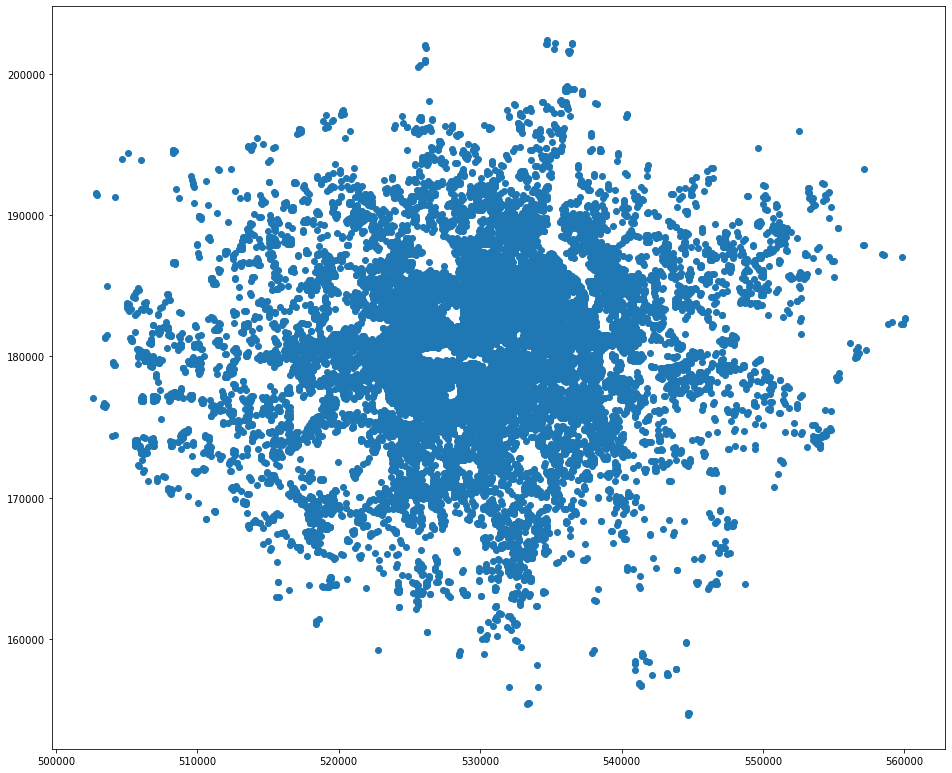

In [19]:
f,ax=plt.subplots(figsize=(16,16))
gdfprof.plot(ax=ax, legend=True, legend_kwds={'loc':'upper right', 'title':'Prof'})

In [21]:
# wl == Ward Listings
wlprof = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wlprof

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id,host_id,host_listings_count,room_type,availability_365,neighbourhood_cleansed,price,GSS_CODE
0,13913,54730,3.0,Private room,343,Islington,$50.00,E05000381
210,89870,54730,3.0,Entire home/apt,343,Islington,$145.00,E05000381
1239,1211331,6614363,3.0,Private room,314,Islington,$51.00,E05000381
1821,2173226,185201,4.0,Private room,0,Islington,$35.00,E05000381
1924,2053193,185201,4.0,Private room,0,Islington,$35.00,E05000381
...,...,...,...,...,...,...,...,...
56408,598124672880076606,28184118,3.0,Entire home/apt,68,Harrow,$500.00,E05000297
60921,651883271748870344,462140387,5.0,Private room,0,Harrow,$100.00,E05000297
58920,631026904518184628,156212093,2.0,Entire home/apt,73,Sutton,$150.00,E05000556
62799,665959349958547726,156212093,2.0,Private room,222,Sutton,$90.00,E05000556


In [22]:
#total
wltotal = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wltotal

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,id,host_id,host_listings_count,room_type,availability_365,neighbourhood_cleansed,price,GSS_CODE
0,13913,54730,3.0,Private room,343,Islington,$50.00,E05000381
210,89870,54730,3.0,Entire home/apt,343,Islington,$145.00,E05000381
1107,993428,5457414,1.0,Private room,221,Islington,$80.00,E05000381
1239,1211331,6614363,3.0,Private room,314,Islington,$51.00,E05000381
1461,1458193,7818548,1.0,Entire home/apt,59,Islington,$142.00,E05000381
...,...,...,...,...,...,...,...,...
68089,707122645619496259,442648422,3.0,Private room,364,Ealing,$50.00,E05000189
41593,41283975,203191779,1.0,Entire home/apt,0,Bexley,$60.00,E05000067
64030,674367058773224946,212238640,1.0,Entire home/apt,132,Bexley,$88.00,E05000067
49322,50729641,409949843,1.0,Private room,0,Croydon,$75.00,E05000157


In [23]:
wardprof = wlprof.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardprof.columns.values
cols[1] = 'profcount'
wardprof.columns = cols
wardprof

,GSS_CODE,profcount
0,E05000026,17
1,E05000027,14
2,E05000028,9
3,E05000029,7
4,E05000030,13
...,...,...
616,E05000646,128
617,E05000647,278
618,E05000648,110
619,E05000649,902


In [24]:
wardtotal = wltotal.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardtotal.columns.values
cols[1] = 'totalcount'
wardtotal.columns = cols
wardtotal

,GSS_CODE,totalcount
0,E05000026,60
1,E05000027,27
2,E05000028,21
3,E05000029,14
4,E05000030,17
...,...,...
620,E05000646,198
621,E05000647,392
622,E05000648,204
623,E05000649,1094


In [25]:
warddata=ward.merge(wardprof, on='GSS_CODE', how='left')
warddata=warddata.merge(wardtotal, on='GSS_CODE', how='left')
warddata['profcount'].fillna(0)
warddata.eval('percent = profcount / totalcount' , inplace=True)
warddata

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,profcount,totalcount,percent
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407....",9.0,16,0.562500
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837....",6.0,15,0.400000
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114....",21.0,37,0.567568
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490....",2.0,14,0.142857
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063....",15.0,33,0.454545
...,...,...,...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391....",10.0,20,0.500000
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988....",13.0,17,0.764706
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712....",7.0,14,0.500000
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377....",4.0,9,0.444444


In [ ]:
warddata["density"]=warddata["profcount"]/warddata.area

In [ ]:
warddata

# Maping

In [ ]:
fig, ax = plt.subplots(figsize =(16,9))
warddata.plot(ax=ax, column = 'percent', cmap = "YlOrRd",  legend = True, figsize=(16, 9))
ax.set_title('Professional Airbnb percentage by London Ward')
plt.savefig('Professional Airbnb percentage by London Ward')

# Moran I

## Global Moran I

In [26]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx

In [27]:
wq = lps.weights.Queen.from_dataframe(ward)   # Quuen's neighours matrix
wq.transform = 'r'  # standarlisation

In [28]:
wq.neighbors[10]

[2, 386, 4, 388, 9, 11, 12]

In [29]:
centroids = ward.geometry.centroid 

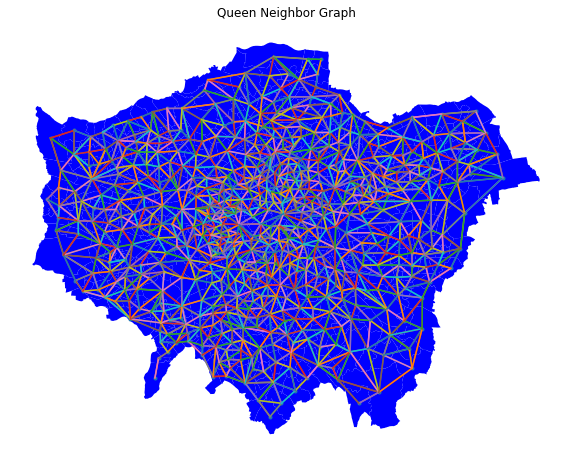

In [30]:
ax = ward.plot(figsize=(10, 10),color='blue')
plt.plot(centroids.x, centroids.y, '.')
for k, neighs in wq.neighbors.items():
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment.x, segment.y, '-')
plt.title('Queen Neighbor Graph')
plt.axis('off')
plt.show()


In [31]:
warddata_m=warddata[["GSS_CODE","percent","geometry"]]
warddata_m
warddata_m.isna().sum()

GSS_CODE    0
percent     4
geometry    0
dtype: int64

In [32]:
warddata_m['percent'] = warddata_m['percent'].fillna(0)
warddata_m["percent"].isna().sum()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0

In [33]:
warddata_m.isna().sum()

GSS_CODE    0
percent     0
geometry    0
dtype: int64

In [70]:

mi=esda.Moran(warddata_m[["percent"]],wq)

print("Moran's I value：",mi.I)
print("random Ztest：",mi.z_rand)
print("random Ztest pvalue: ", mi.p_rand)
print("normal Ztest：",mi.z_norm)
print("normal Ztest Pvalue：",mi.p_norm)


Moran's I value： 0.33463037372108767
random Ztest： 14.21739214221526
random Ztest pvalue:  0.0
normal Ztest： 14.216305657040298
normal Ztest Pvalue： 0.0


## Local Moran I

In [35]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

In [71]:
y = warddata_m['percent'].values
# w = lps.weights.distance.Kernel.from_dataframe(gdf_drop, fixed=False, k=15)
# w.transform = 'r'
moran_loc = Moran_Local(y, wq)

In [72]:
loc_moran_df = pd.DataFrame({'name':warddata_m.GSS_CODE, 'loc_moran':moran_loc.Is}) # moran_loc.Is
print(loc_moran_df)

          name  loc_moran
0    E05000405  -0.593615
1    E05000414   0.463261
2    E05000401  -0.106555
3    E05000400  -0.408134
4    E05000402   0.012256
..         ...        ...
620  E05000042   0.239627
621  E05000030   2.009527
622  E05000029   0.158231
623  E05000037  -0.113694
624  E09000001   1.730347

[625 rows x 2 columns]


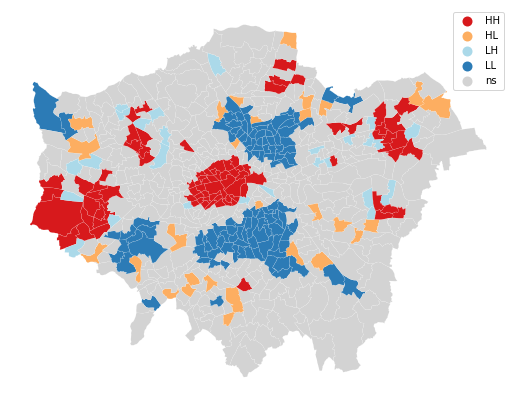

In [73]:

fig, ax = lisa_cluster(moran_loc, warddata_m, p=0.1, figsize = (9,9))

In [41]:
counts = pd.value_counts(moran_loc.q)
counts

3    224
1    209
2    102
4     90
dtype: int64

#the actual quadrants is as follows:   
1 represents observations in the HH quadrant  
2 those in the LH one  
3 in the LL region  
4 in the HL quadrant. 

## Global Moran I for 2016, 2019, 2020, 2021

In [42]:
url2016="https://orca.casa.ucl.ac.uk/~jreades/data/London-2016-02-02-listings.csv.gz"
url2019="https://orca.casa.ucl.ac.uk/~jreades/data/London-2019-11-listings.csv.gz"
url2020="https://orca.casa.ucl.ac.uk/~jreades/data/London-2020-11-listings.csv.gz"
url2021="https://orca.casa.ucl.ac.uk/~jreades/data/London-2021-10-listings.csv.gz"

airbnb_origin2016 =pd.read_csv(url2016, compression='gzip', low_memory=False)
airbnb_origin2019 =pd.read_csv(url2019, compression='gzip', low_memory=False)
airbnb_origin2020 =pd.read_csv(url2020, compression='gzip', low_memory=False)
airbnb_origin2021 =pd.read_csv(url2021, compression='gzip', low_memory=False)


In [45]:
airbnb2016 = airbnb_origin2016[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

In [46]:
airbnbprof2016 = airbnb2016[airbnb2016['host_listings_count']>1 ]
gdfprof2016 = gpd.GeoDataFrame(airbnbprof2016, 
      geometry=gpd.points_from_xy(airbnbprof2016['longitude'], airbnbprof2016['latitude'], crs='epsg:4326'))
gdfprof2016 = gdfprof.to_crs('epsg:27700')

In [57]:

#prof2016
gdfprof_16 = gpd.GeoDataFrame(airbnbprof2016, 
      geometry=gpd.points_from_xy(airbnbprof2016['longitude'], airbnbprof2016['latitude'], crs='epsg:4326'))
gdfprof_16 = gdfprof.to_crs('epsg:27700')

#total2016
gdftotal_16 = gpd.GeoDataFrame(airbnb2016, 
      geometry=gpd.points_from_xy(airbnb2016['longitude'], airbnb2016['latitude'], crs='epsg:4326'))
gdftotal_16 = gdftotal.to_crs('epsg:27700')

#Join 2016 
wlprof_16 = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

wltotal_16 = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])


/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [58]:
wardprof_16 = wlprof_16.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardprof_16.columns.values
cols[1] = 'profcount'
wardprof_16.columns = cols

wardtotal_16 = wltotal_16.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardtotal_16.columns.values
cols[1] = 'totalcount'
wardtotal_16.columns = cols


warddata_16=ward.merge(wardprof_16, on='GSS_CODE', how='left')
warddata_16=warddata_16.merge(wardtotal_16, on='GSS_CODE', how='left')
warddata_16['profcount'].fillna(0)
warddata_16.eval('percent = profcount / totalcount' , inplace=True)

In [60]:
warddata_16_m=warddata_16[["GSS_CODE","percent","geometry"]]
warddata_16_m
warddata_16_m.isna().sum()

GSS_CODE    0
percent     4
geometry    0
dtype: int64

In [64]:
warddata_16_m['percent'] = warddata_16_m['percent'].fillna(0)
warddata_16_m["percent"].isna().sum()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0

In [75]:
mi=esda.Moran(warddata_16_m[["percent"]],wq)

print("Moran's I value：",mi.I)
print("random Ztest：",mi.z_rand)
print("random Ztest pvalue: ", mi.p_rand)
print("normal Ztest：",mi.z_norm)
print("normal Ztest Pvalue：",mi.p_norm)

Moran's I value： 0.33463037372108767
random Ztest： 14.21739214221526
random Ztest pvalue:  0.0
normal Ztest： 14.216305657040298
normal Ztest Pvalue： 0.0


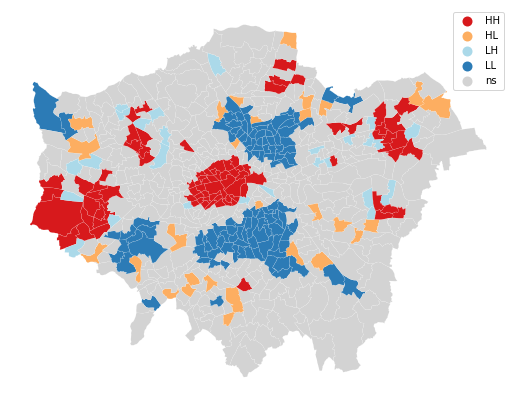

In [97]:
y_16 = warddata_16_m['percent'].values
# w = lps.weights.distance.Kernel.from_dataframe(gdf_drop, fixed=False, k=15)
# w.transform = 'r'

moran_loc_16 = Moran_Local(y_16, wq)

loc_moran_df_16 = pd.DataFrame({'name':warddata_16_m.GSS_CODE, 'loc_moran':moran_loc_16.Is}) # moran_loc.Is

fig, ax = lisa_cluster(moran_loc, warddata_m, p=0.1, figsize = (9,9))


In [85]:
ax_16

<AxesSubplot:>

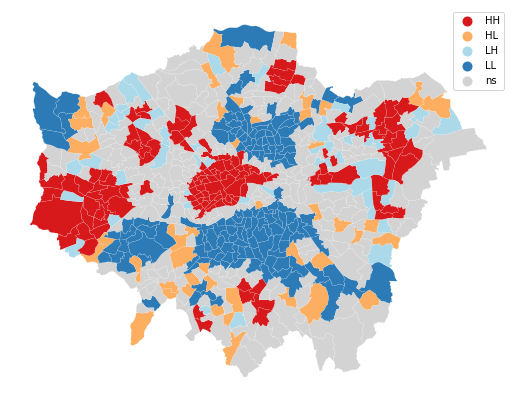

In [96]:
fig, ax_16 = lisa_cluster(moran_loc_16, warddata_16_m, p=0.2, figsize = (9,9))

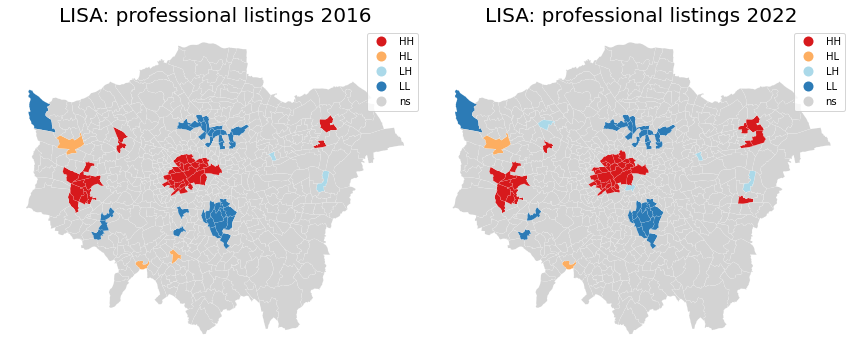

In [126]:
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Make the axes accessible with single indexing
axs = axs.flatten()
#ax1 = axes[0]
#ax2 = axes[1]

esdaplot.lisa_cluster(moran_loc, warddata_m, p=0.01, ax=axs[0])
ax1.set_title("2016")

esdaplot.lisa_cluster(moran_loc_16, warddata_16_m, p=0.01, ax=axs[1])
ax2.set_title("2022")

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "LISA: professional listings 2016",
            "LISA: professional listings 2022",
        ][i],
        y=1,fontsize=20
    )

# Tight layout to minimise in-betwee white space
f.tight_layout()
plt.show()
# Set title to each subplot




In [ ]:
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()


AttributeError: 'tuple' object has no attribute 'plot'

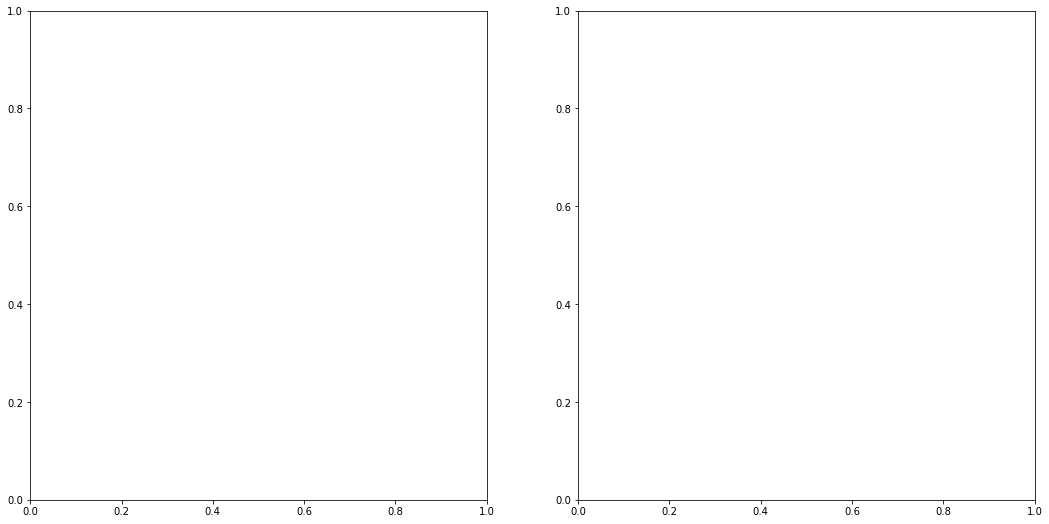

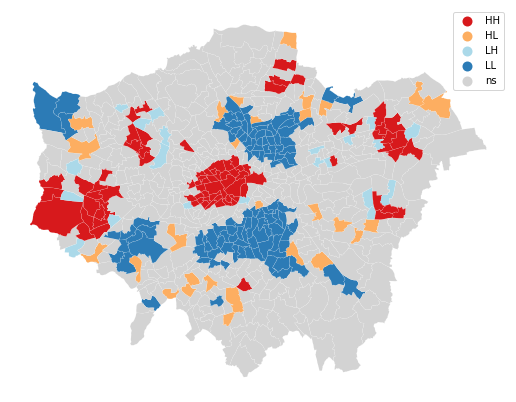

In [88]:
# Set up a 1 x 2 plot (you can also leave off the nrows= and ncols=)
f,axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))
# ax1 will be the first plot on the left, ax2 will be on the right;
# a 2 (or more) *row* plot will return a list of lists... 1 list/row.
ax1 = axes[0]
ax2 = axes[1]

# Left plot is the median price
lisa_cluster(moran_loc_16, warddata_16_m, p=0.1, figsize = (9,9)).plot (ax=ax1, legend=True)
ax1.set_title("2016");
# Turn off the frame, one side of the plat at a time
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
# Set the labels
ax1.set_xlabel("Easting");
ax1.set_ylabel("Northing");

# Right plot is the number of listings; note
# here the use of both zorder (which is the 
# 'stacking order' of elements on the plot, and
# the legend_kwds (keywords) to change the 
# orientation of the plot to horizontal
fig, ax.plot(ax=ax2, legend=True)
ax2.set_title("2022");
# Set a background colour for the plot
# Add grid lines and set their zorder to
# below that of the data on the plot
# This is equivalent to the ax1.spines... 
# above, but if you use it here you lose
# the background to the plot as well!
#plt.gca().set(frame_on=False)

# Remove the labels on the ticks of the 
# axes (meaning: remove the numbers on 
# x- and y-axes).


# Set the labels

In [44]:
clean_dataframe_column_names(airbnb_origin2016)
clean_dataframe_column_names(airbnb_origin2019)
clean_dataframe_column_names(airbnb_origin2020)
clean_dataframe_column_names(airbnb_origin2021)

airbnbprof2016 = airbnb2016[airbnb2016['host_listings_count']>1 ]
airbnbprof2019 = airbnb2019[airbnb2019['host_listings_count']>1 ]
airbnbprof2020 = airbnb2020[airbnb2020['host_listings_count']>1 ]
airbnbprof2021 = airbnb2021[airbnb2021['host_listings_count']>1 ]

gdfprof2019 = gpd.GeoDataFrame(airbnbprof2019, 
      geometry=gpd.points_from_xy(airbnbprof2019['longitude'], airbnbprof2019['latitude'], crs='epsg:4326'))
gdfprof2019 = gdfprof.to_crs('epsg:27700')

gdfprof2016 = gpd.GeoDataFrame(airbnbprof2016, 
      geometry=gpd.points_from_xy(airbnbprof2016['longitude'], airbnbprof2016['latitude'], crs='epsg:4326'))
gdfprof2016 = gdfprof.to_crs('epsg:27700')


gdfprof2021 = gpd.GeoDataFrame(airbnbprof2021, 
      geometry=gpd.points_from_xy(airbnbprof2021['longitude'], airbnbprof2021['latitude'], crs='epsg:4326'))
gdfprof = gdfprof.to_crs('epsg:27700')


gdfprof2020 = gpd.GeoDataFrame(airbnbprof2020, 
      geometry=gpd.points_from_xy(airbnbprof2020['longitude'], airbnbprof2020['latitude'], crs='epsg:4326'))
gdfprof2020 = gdfprof.to_crs('epsg:27700')

NameError: name 'airbnb2016' is not defined